# Predicting with an ONNX model

<img src="../../img/ONNX_Runtime_logo_dark.png" width="500"/>

This notebook demonstrates how we can use an ONNX model to produce predictions over a geospatial scene using Raster Vision. We will see how Raster Vision allows configuring each part of the prediction workflow: reading the input imagery, the prediction itself, and writing the outputs to file.

The model we will use is a semantic segmentation model trained to segment clouds in Sentinel-2 imagery. It has been trained on the [Azavea Cloud Dataset](https://www.azavea.com/blog/2021/02/08/cloud-detection-in-satellite-imagery/).

---

## Setup

In [ ]:
%pip install -q pystac_client

In [ ]:
%env AWS_NO_SIGN_REQUEST=YES

In [3]:
import os

import pystac_client
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()


from rastervision.core.box import Box
from rastervision.core.data import (ClassConfig, PolygonVectorOutputConfig,
                                    Scene, SemanticSegmentationLabelStore,
                                    XarraySource)
from rastervision.core.data.raster_source.stac_config import subset_assets
from rastervision.core.rv_pipeline import SemanticSegmentationPredictOptions
from rastervision.pytorch_learner import (
    DataConfig, SemanticSegmentationLearner, SemanticSegmentationLearnerConfig)
from rastervision.pytorch_learner.utils.prediction import predict_scene_ss

In [4]:
BANDS = [
    'coastal',  # B01
    'blue',  # B02
    'green',  # B03
    'red',  # B04
    'rededge1',  # B05
    'rededge2',  # B06
    'rededge3',  # B07
    'nir',  # B08
    'nir08',  # B8A
    'nir09',  # B09
    'swir16',  # B11
    'swir22',  # B12
]

In [5]:
out_dir = './cloud-detection/'
model_uri = 's3://azavea-research-public-data/raster-vision/examples/s2-cloud-detection/cloud-resnet18.onnx'

## Fetch Sentinel-2 imagery from the EarthSearch STAC API

We use imagery over Paris, France from February 02, 2024.

In [6]:
bbox = Box(ymin=48.81, xmin=2.22, ymax=48.98, xmax=2.475)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [27]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
items = catalog.search(
    intersects=bbox_geometry, 
    datetime='2024-02-02',
    collections=['sentinel-2-c1-l2a'],
).item_collection()
len(items)

1

Subset the STAC Item's assets:

In [8]:
item = subset_assets(items[-1], BANDS)

## Define a [Scene](./scenes_and_aois.ipynb)

In [10]:
raster_source = XarraySource.from_stac(
    item,
    bbox_map_coords=tuple(bbox),
    stackstac_args=dict(rescale=False, fill_value=0),
    allow_streaming=True,
)
raster_source.shape

(1874, 1885, 12)

In [11]:
class_config = ClassConfig(names=['bg', 'cloud'], null_class='bg')
label_store = SemanticSegmentationLabelStore(
    uri=out_dir,
    class_config=class_config,
    bbox=raster_source.bbox,
    crs_transformer=raster_source.crs_transformer,
    vector_outputs=[PolygonVectorOutputConfig(class_id=1)],
    smooth_output=True,
)

Put them together in a `Scene`:

In [12]:
scene = Scene(id='', raster_source=raster_source, label_store=label_store)

## Instantiate a `Learner` in inference mode

In the output below, we can see the onnxruntime trying to load the TensorRT runtime and then falling back to the CUDA runtime. You might see a different output depending on your environment.

In [14]:
learner = SemanticSegmentationLearner(
    cfg=SemanticSegmentationLearnerConfig(
        data=DataConfig(class_config=class_config, img_sz=512)),
    model_weights_path=model_uri,
    training=False,
)

2024-04-09 20:48:32:rastervision.pytorch_learner.learner: INFO - Loading ONNX model from s3://azavea-research-public-data/raster-vision/examples/s2-cloud-detection/cloud-resnet18.onnx
2024-04-09 20:48:32:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/s2-cloud-detection/cloud-resnet18.onnx.
2024-04-09 20:48:32:rastervision.pytorch_learner.utils.utils: INFO - Using ONNX execution providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:456 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(onnxruntime::python::PySessionOptions&, const ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.
****************************************


2024-04-09 20:48:32.150151415 [E:onnxruntime:Default, provider_bridge_ort.cc:1532 TryGetProviderInfo_TensorRT] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1209 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_tensorrt.so with error: libnvinfer.so.8: cannot open shared object file: No such file or directory



Check which ONNX runtimes are available:

In [15]:
learner.model.ort_session.get_providers()

['CUDAExecutionProvider', 'CPUExecutionProvider']

## Run prediction

In [16]:
pred_opts = SemanticSegmentationPredictOptions(
    chip_sz=512, stride=256, crop_sz='auto', batch_sz=8)

Run inference. This may be a little slow as the chips are being read from a remote file. To pre-load the entire Sentinel-2 tile into memory, you can run `raster_source.data_array.load()`.

In [17]:
labels = predict_scene_ss(learner, scene, pred_opts)

Making predictions on :   0%|          | 0/64 [00:00<?, ?it/s]

2024-04-09 20:48:42:rastervision.pytorch_learner.learner: INFO - Running inference with ONNX runtime.


Save to disk:

In [18]:
scene.label_store.save(labels)

Saving pixel labels:   0%|          | 0/4 [00:00<?, ?it/s]

Saving pixel scores:   0%|          | 0/4 [00:00<?, ?it/s]

2024-04-09 20:50:03:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Writing vector outputs to disk.


Vectorizing predictions:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
!tree {out_dir}

./cloud-detection/
├── labels.tif
├── pixel_hits.npy
├── scores.tif
└── vector_output
    └── class-1-cloud.json

1 directory, 4 files


---

## Vsiualize results

For completeness, we visualize the outputs of the model below. For a more thorough inspection, you can load the outputs in a tool like QGIS.

### Probability raster

In [20]:
score = labels.get_score_arr(labels.extent)

In [21]:
from rastervision.core.data import RasterioCRSTransformer, RasterioSource

In [22]:
rgb_uri = items[-1].assets['visual'].href
crs_transformer = RasterioCRSTransformer.from_uri(rgb_uri)
raster_source_viz = RasterioSource(
    rgb_uri, bbox=crs_transformer.map_to_pixel(bbox).normalize())
raster_source_viz.shape

2024-04-09 20:50:19:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/http/sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/DQ/2024/2/S2A_31UDQ_20240202_0_L2A/TCI.tif.


(1874, 1885, 3)

In [23]:
img_rgb = raster_source_viz[:, :]
img_rgb.shape

(1874, 1885, 3)

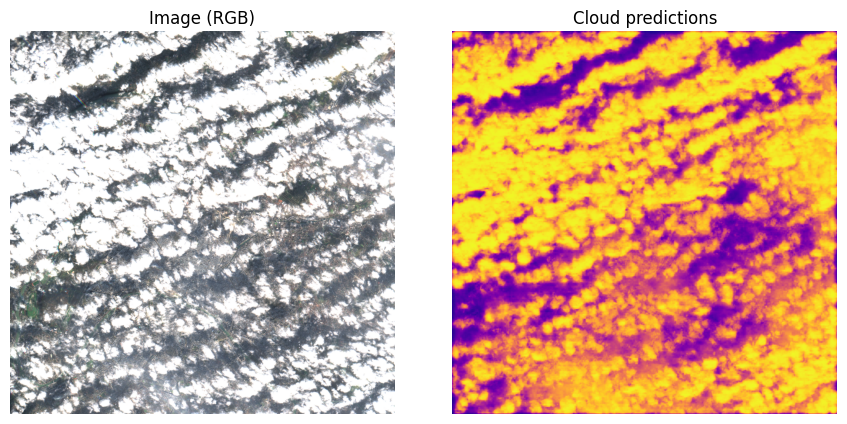

In [26]:
fig, (ax_img, ax_pred) = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout()
ax_img.imshow(img_rgb)
ax_img.set_title('Image (RGB)')
ax_img.axis('off')
ax_pred.imshow(score[1], cmap='plasma')
ax_pred.set_title('Cloud predictions')
ax_pred.axis('off')
plt.show()

### Vector predictions

We can load the vector output using GeoPandas and then display it over an interactive map using Folium:

In [ ]:
%pip install -q folium

In [ ]:
from os.path import join
import folium
import numpy as np
import geopandas as gpd

gdf = gpd.read_file(join(out_dir, 'vector_output', 'class-1-cloud.json'))
loc = np.array(gdf.unary_union.centroid.xy).squeeze().tolist()[::-1]
m = folium.Map(location=loc, zoom_start=12)
folium.GeoJson(gdf).add_to(m)
m

![A screenshot of an interative Folium Map with vector predictions.](../../img/folium_vector_preds.png "A screenshot of an interative Folium Map with vector predictions.")